# Visualize CMIP6 model trend variability data

I have now pre-processed the gridded monthly model output into trends for CESM1 PI-Control simulation.

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

__I am going to visualize the trend uncertainty from climate variability now.__

## Code

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

%matplotlib inline

### Load processed trend data

In [2]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [6]:
cesm1_trends_filepath   = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_trends_filepath     = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_trends_filepath = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_trends_filepath   = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [12]:
cesm1_pic_trends_all   = xr.open_dataarray(*cesm1_trends_filepath)

mpi_pic_trends_all     = xr.open_dataarray(*mpi_trends_filepath)

canesm2_pic_trends_all = xr.open_dataarray(*canesm2_trends_filepath)

esm2m_pic_trends_all   = xr.open_dataarray(*esm2m_trends_filepath)

### Define functions

In [17]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [18]:
def percentile_vec(data,core_dim:str,q,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

Visualize different standard deviations for different regions.

In [41]:
cesm1_pic_trends_std   = cesm1_pic_trends_all.std(dim='startyear',skipna=True)

mpi_pic_trends_std     = mpi_pic_trends_all.std(dim='startyear',skipna=True)

canesm2_pic_trends_std = canesm2_pic_trends_all.std(dim='startyear',skipna=True)

esm2m_pic_trends_std   = esm2m_pic_trends_all.std(dim='startyear',skipna=True)

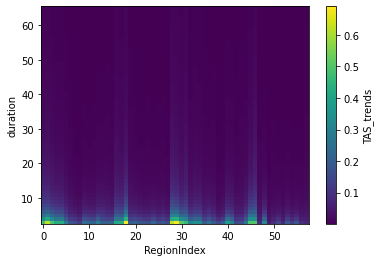

In [23]:
cesm1_pic_trends_std.plot()

Text(0.5, 0.9, 'CESM1 Variability')

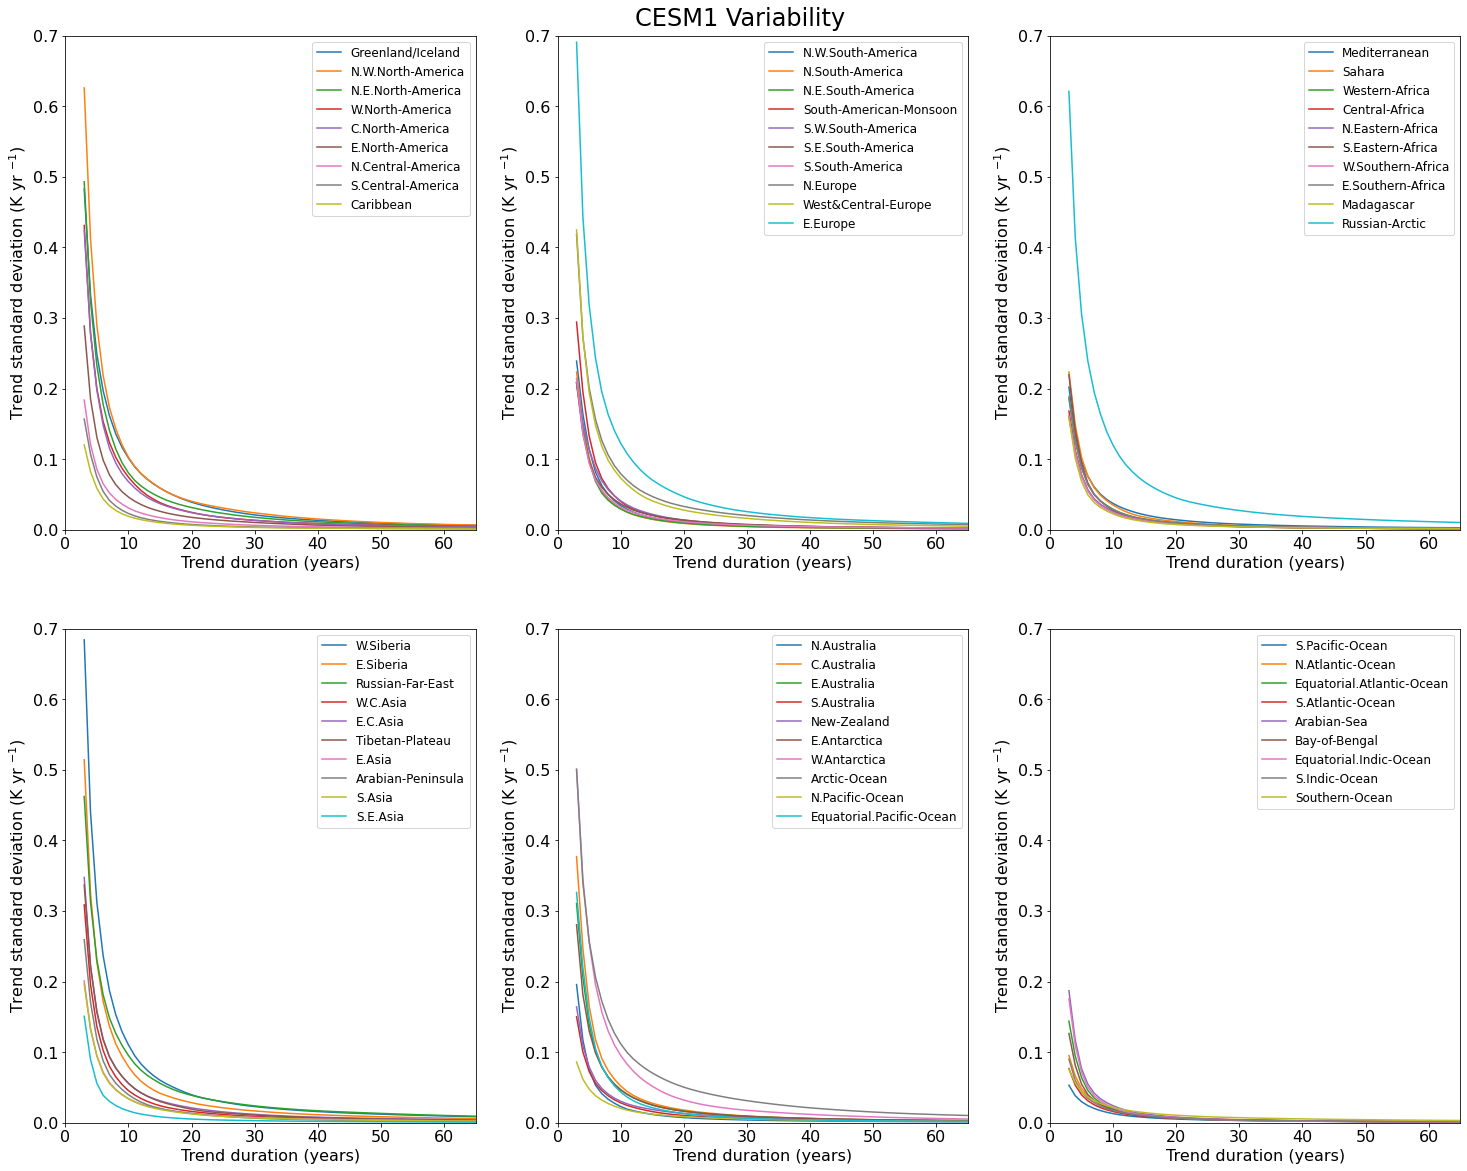

In [39]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in cesm1_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = cesm1_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('CESM1 Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'MPI-GE Variability')

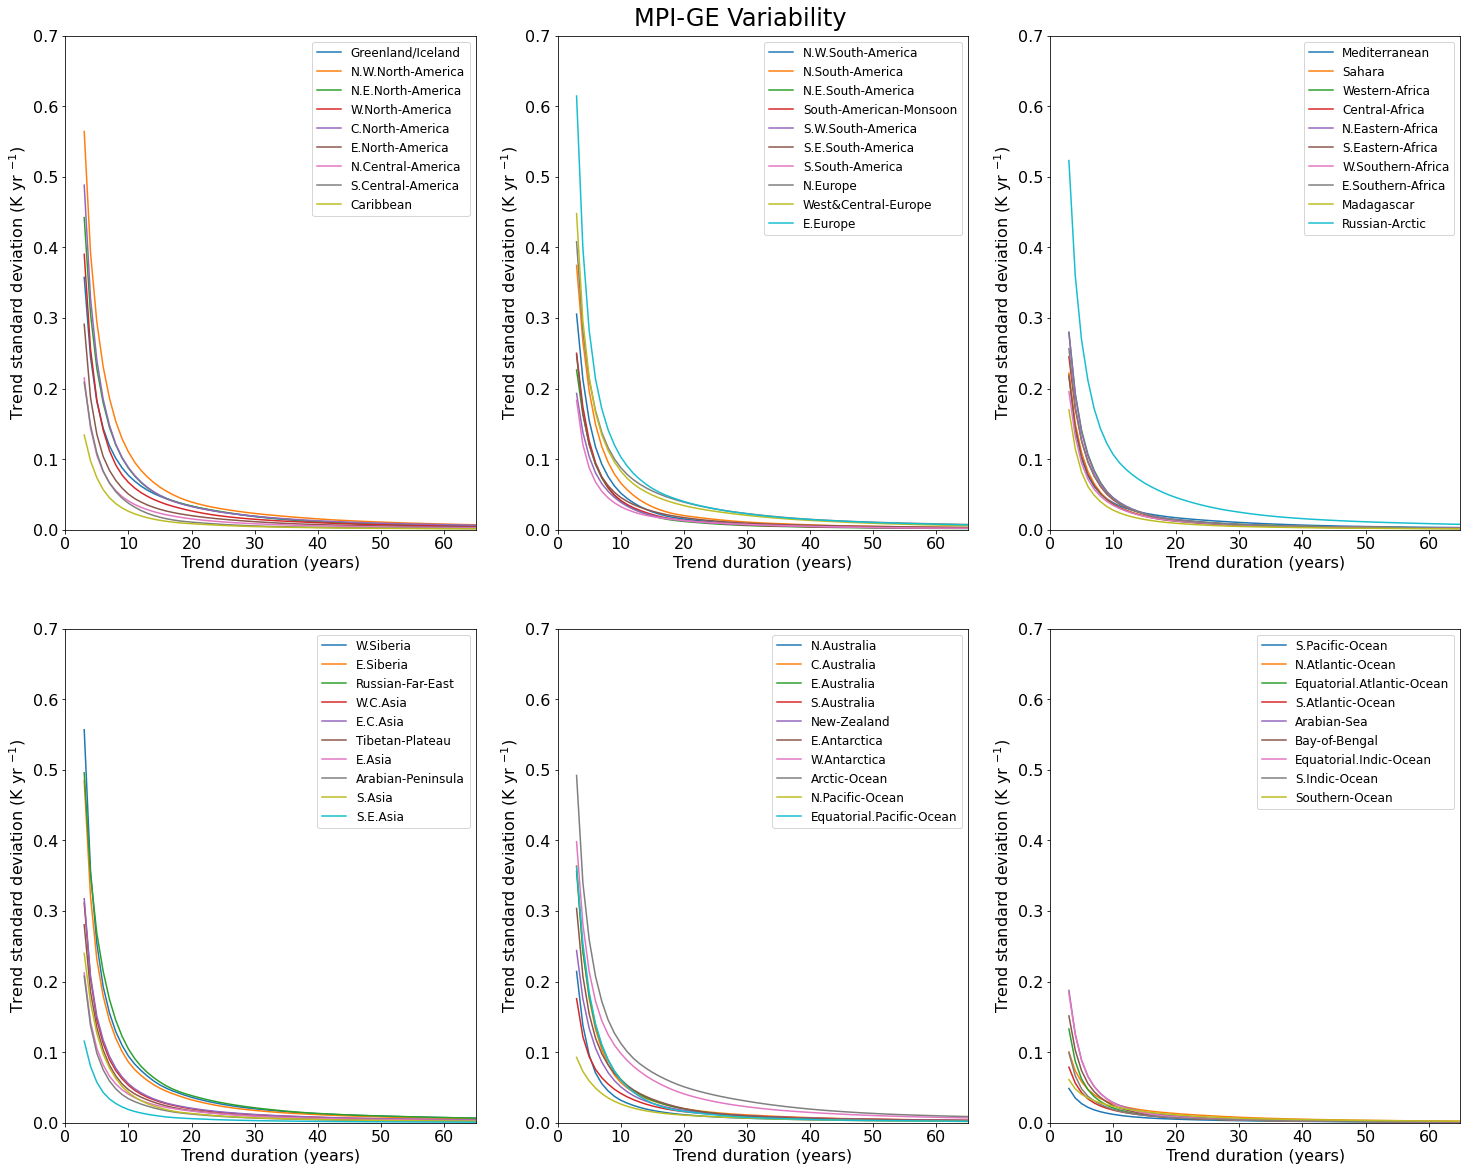

In [42]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in mpi_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = mpi_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('MPI-GE Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'CanESM2 Variability')

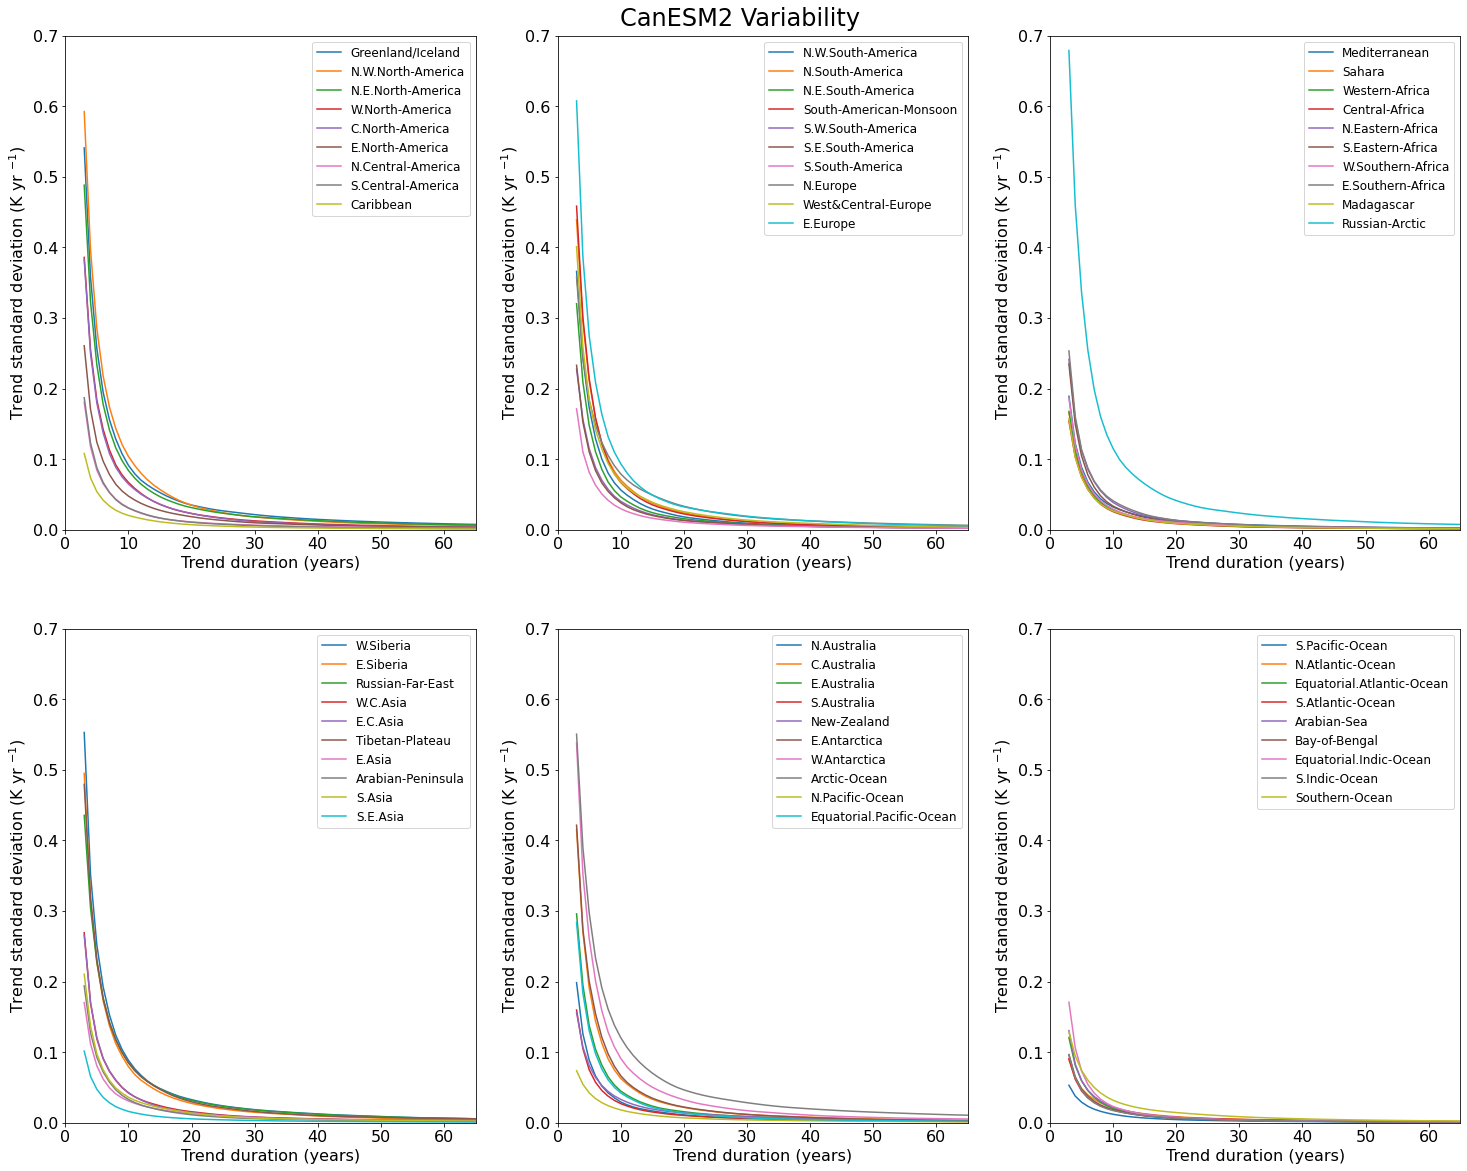

In [44]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in canesm2_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = canesm2_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('CanESM2 Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'ESM2M Variability')

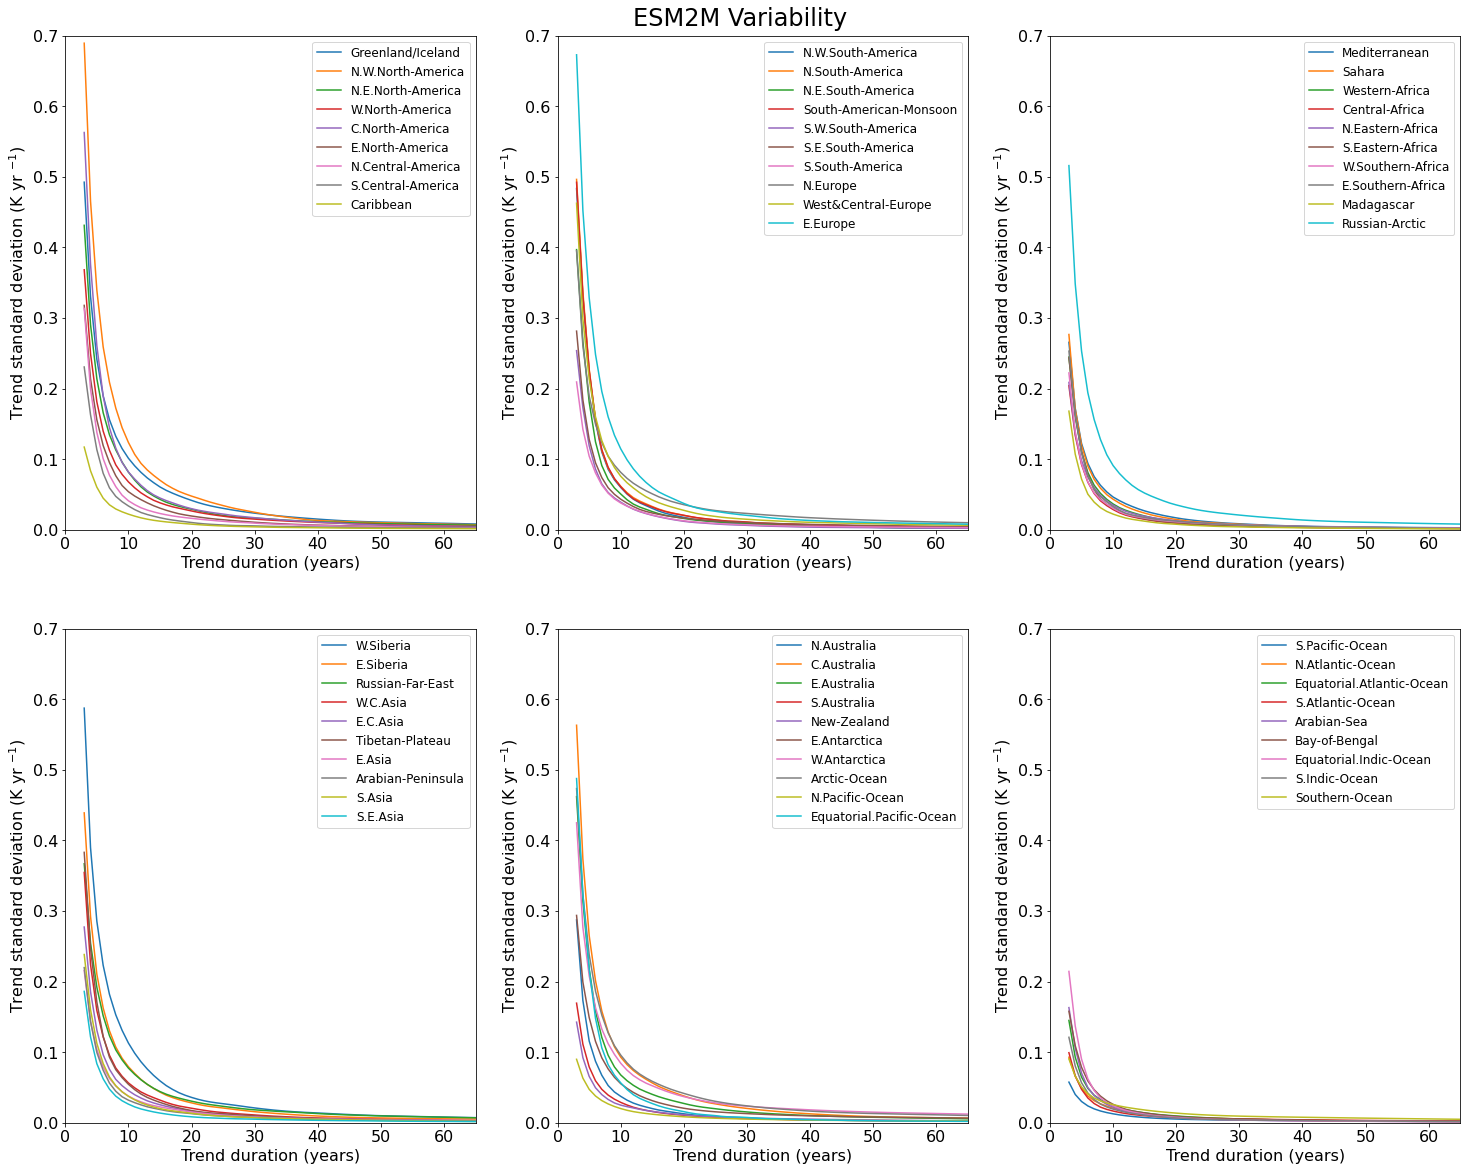

In [45]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in esm2m_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = esm2m_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('ESM2M Variability',fontsize=24,x=0.5,y=0.90)

### Plot ideas!

Create a spatial plot with the trend standard deviation at 5 or 10 years for each region so we can visualize it!

Normalize according to the Weatherhead math to evaluate the AR1 assumption.

#### Create a spatial plot with the trend standard deviation at 5 or 10 years for each region so we can visualize it!

In [26]:
import regionmask

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

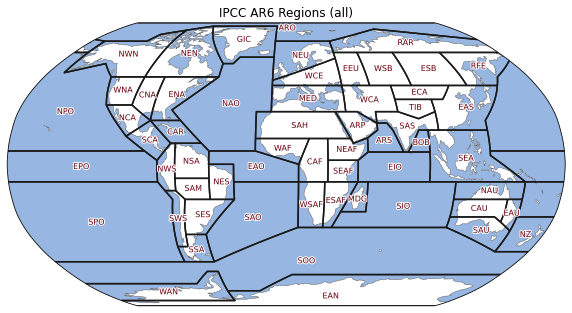

In [27]:
ipcc_ar6_regions_all   = regionmask.defined_regions.ar6.all

text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)

_fig,_ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.Robinson()})

_ax.set_title('IPCC AR6 Regions (all)')

ax = ipcc_ar6_regions_all.plot(ax = _ax,
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()


In [47]:
ipcc_ar6_regions_all.numbers

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57]

Generalized

In [56]:
ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

cesm1_unc_mask   = unc_mask.copy()
mpi_unc_mask     = unc_mask.copy()
canesm2_unc_mask = unc_mask.copy()
esm2m_unc_mask   = unc_mask.copy()

del unc_mask

for i in ipcc_ar6_regions_all.numbers:
        
    # Replace the mask value with the 10-year trend standard deviation.
    cesm1_unc_mask   = xr.where(cesm1_unc_mask==i,cesm1_pic_trends_std.sel(RegionIndex=i,duration=10),cesm1_unc_mask)
    mpi_unc_mask     = xr.where(mpi_unc_mask==i,mpi_pic_trends_std.sel(RegionIndex=i,duration=10),mpi_unc_mask)
    canesm2_unc_mask = xr.where(canesm2_unc_mask==i,canesm2_pic_trends_std.sel(RegionIndex=i,duration=10),canesm2_unc_mask)
    esm2m_unc_mask   = xr.where(esm2m_unc_mask==i,esm2m_pic_trends_std.sel(RegionIndex=i,duration=10),esm2m_unc_mask)
    

In [53]:
ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

for i in cesm1_pic_trends_std.RegionIndex:
        
    # Replace the mask value with the 10-year trend standard deviation.
    unc_mask = xr.where(unc_mask==i.values,cesm1_pic_trends_std.sel(RegionIndex=i.values,duration=10),unc_mask)

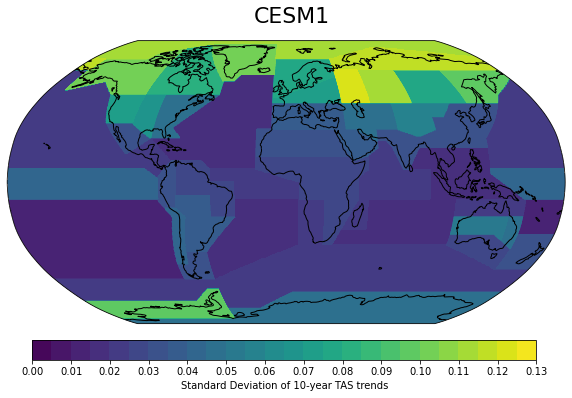

In [102]:
model_name = 'CESM1'
_unc_mask = cesm1_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

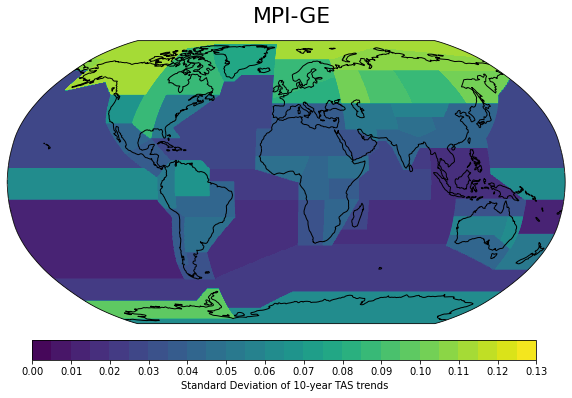

In [97]:
model_name = 'MPI-GE'
_unc_mask = mpi_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

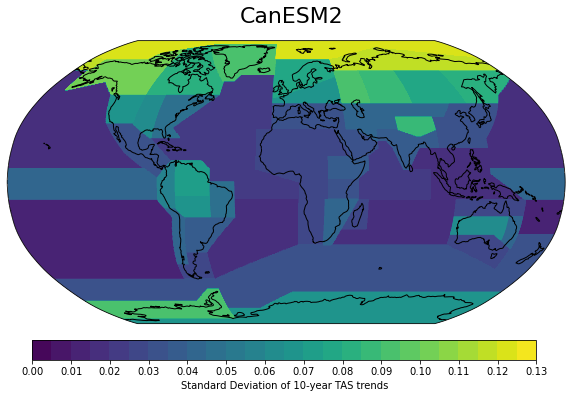

In [98]:
model_name = 'CanESM2'
_unc_mask = canesm2_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

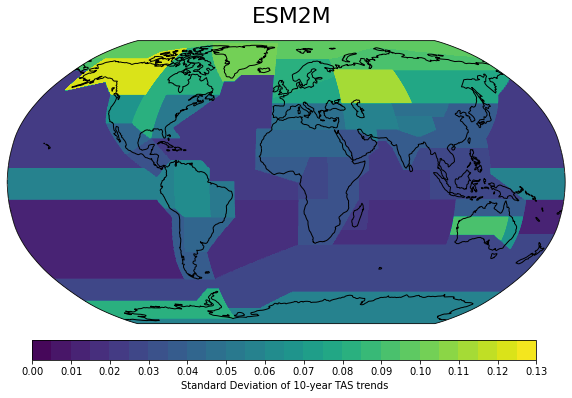

In [99]:
model_name = 'ESM2M'
_unc_mask = esm2m_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

In [100]:
from functions import sp_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


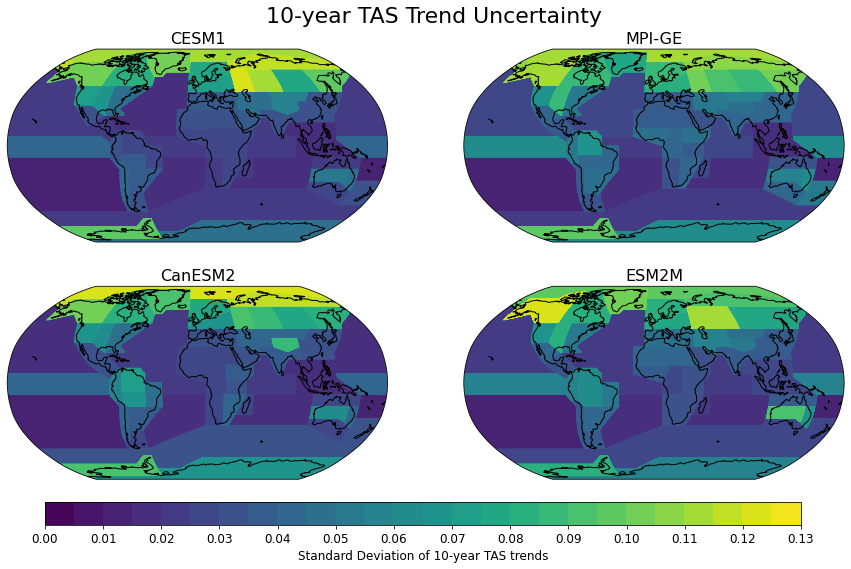

In [122]:
fig,axs = sp_map(2,2,projection=ccrs.Robinson(),figsize=(15,8))
axs = axs.flat

cax = plt.axes([0.16, 0.05, 0.7, 0.04])

masks = [cesm1_unc_mask,mpi_unc_mask,canesm2_unc_mask,esm2m_unc_mask]
models = ['CESM1','MPI-GE','CanESM2','ESM2M']

for _ax,_mask,_label in zip(axs,masks,models):
    
    im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                      transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

    _ax.coastlines()
    _ax.set_global()
    _ax.set_title(_label,fontsize=16)

cbar = fig.colorbar(im,orientation='horizontal',
                    ticks=np.linspace(0,0.13,14),
                    cax=cax,
                   )

cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Standard Deviation of 10-year TAS trends',fontsize=12)

fig.suptitle('10-year TAS Trend Uncertainty',fontsize=22,x=0.52,y=0.95)

plt.show()

Calculate a 95% confidence interval on the PI-Control trends.

In [19]:
trends_2_5perc  = percentile_vec(cesm1_pic_trends_all,q=2.5,core_dim='startyear').compute()
trends_97_5perc = percentile_vec(cesm1_pic_trends_all,q=97.5,core_dim='startyear').compute()

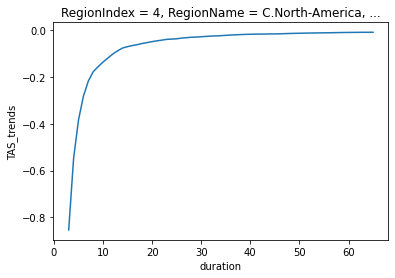

In [20]:
trends_2_5perc.sel(RegionIndex=4).plot()

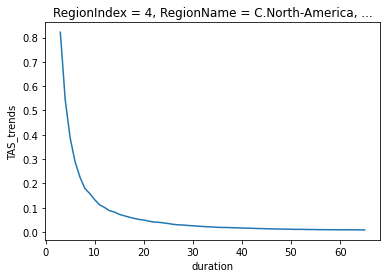

In [21]:
trends_97_5perc.sel(RegionIndex=4).plot()

Example code from the documentation looks super helpful:
https://regionmask.readthedocs.io/en/stable/notebooks/mask_2D.html


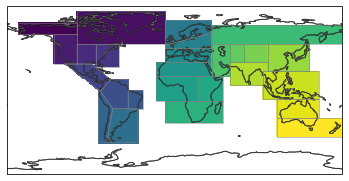

In [100]:
lon = np.arange(-179.5, 180)
lat = np.arange(-89.5, 90)

mask = regionmask.defined_regions.srex.mask(lon, lat)

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

regionmask.defined_regions.srex.plot(
    ax=ax, add_label=False, line_kws=dict(lw=0.5, color="0.5")
)

mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

In [102]:
regionmask.defined_regions.srex

<regionmask.Regions>
Name:     SREX
Source:   Seneviratne et al., 2012 (https://www.ipcc.ch/site/assets/uploads/2...
overlap:  False

Regions:
  1  ALA        Alaska/N.W. Canada
  2  CGI      Canada/Greenl./Icel.
  3  WNA          W. North America
  4  CNA          C. North America
  5  ENA          E. North America
..   ...                       ...
 22  EAS                   E. Asia
 23  SAS                   S. Asia
 24  SEA                 S.E. Asia
 25  NAU              N. Australia
 26  SAU  S. Australia/New Zealand

[26 regions]

In [ ]:
regionmask.Regions.plot

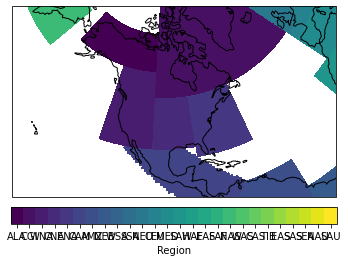

In [101]:
proj = ccrs.LambertConformal(central_longitude=-100)
ax = plt.subplot(111, projection=proj)

low = mask.min()
high = mask.max()

levels = np.arange(low - 0.5, high + 1)

h = mask.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), levels=levels, add_colorbar=False
)

# for colorbar: find abbreviations of all regions that were selected
reg = np.unique(mask.values)
reg = reg[~np.isnan(reg)]
abbrevs = regionmask.defined_regions.srex[reg].abbrevs

cbar = plt.colorbar(h, orientation="horizontal", fraction=0.075, pad=0.05)

cbar.set_ticks(reg)
cbar.set_ticklabels(abbrevs)
cbar.set_label("Region")

ax.coastlines()

# fine tune the extent
ax.set_extent([200, 330, 10, 75], crs=ccrs.PlateCarree())

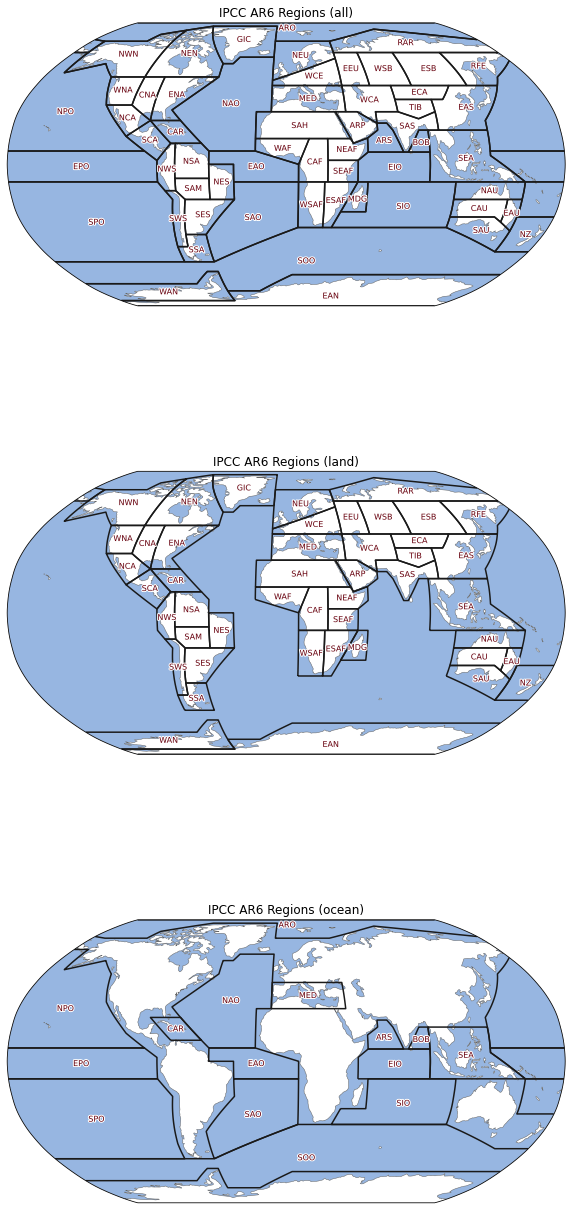

In [10]:
ipcc_ar6_regions_all   = regionmask.defined_regions.ar6.all
ipcc_ar6_regions_land  = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_ocean = regionmask.defined_regions.ar6.ocean

text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)

_fig,_axs = plt.subplots(3,1,figsize=(10,24),subplot_kw={'projection':ccrs.Robinson()})
_fig.subplots_adjust(hspace=0.1)

_axs[0].set_title('IPCC AR6 Regions (all)')
_axs[1].set_title('IPCC AR6 Regions (land)')
_axs[2].set_title('IPCC AR6 Regions (ocean)')

ax = ipcc_ar6_regions_all.plot(ax = _axs[0],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

ax = ipcc_ar6_regions_land.plot(ax = _axs[1],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

ax = ipcc_ar6_regions_ocean.plot(ax = _axs[2],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

In [43]:
out2 = out.compute()

In [37]:
out_np

array([[[0.80553845, 1.01153086, 0.80382594, ..., 0.26736449,
         0.44375706, 0.81355714]],

       [[0.55199149, 0.6961461 , 0.53946703, ..., 0.17970588,
         0.30687304, 0.57051897]],

       [[0.40873468, 0.49334133, 0.3890094 , ..., 0.13136953,
         0.22197924, 0.43031163]],

       ...,

       [[0.01081933, 0.01165296, 0.00883455, ..., 0.00564307,
         0.00568913, 0.00890171]],

       [[0.01056568, 0.01132214, 0.00873627, ..., 0.00550639,
         0.0056943 , 0.00858489]],

       [[0.01041596, 0.01107402, 0.00835967, ..., 0.00543816,
         0.00560141, 0.00814169]]])

In [44]:
out2

<xarray.DataArray 'TAS_trends' (duration: 63, RegionIndex: 46)>
array([[0.80553845, 1.01153086, 0.80382594, ..., 0.26736449, 0.44375706,
        0.81355714],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45
  * duration      (duration) int64 3 4 5 6 7 8 9 10 ... 58 59 60 61 62 63 64 65
    RegionName    (RegionIndex) object 'Greenland/Iceland' ... 'W.Antarctica'
    RegionAbbrev  (RegionIndex) object 'GIC' 'NWN' 'NEN' ... 'NZ' 'EAN' 'WAN'

In [10]:
def calc_lag1_autocorr_vec(data,core_dim:str,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(calc_lag1_autocorr,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs=kwargs,                   # Keyword arguments for the function
                             # dask = 'allowed',              # Dask?
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out

def calc_standardize_vec(data,core_dim:str,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(standardize,            # Function to apply
                             data_chunk,                          # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             output_core_dims=[[core_dim]],   # Dimension(s) to apply the function over
                             kwargs=kwargs,     # Keyword arguments for the function
                             # dask = 'allowed',              # Dask?
                             dask="parallelized",          # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)              # Vectorize
    
    return res_out

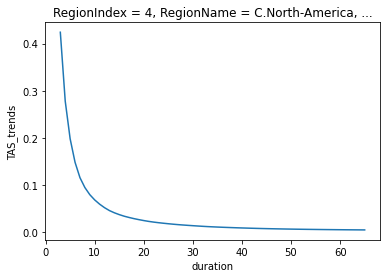

In [10]:
cesm1_pic_trends_all.sel(RegionIndex=4).std(dim='startyear').plot()

In [11]:
ex_out = cesm1_pic_trends_all.std(dim='startyear')

In [21]:
ex_out.sel(RegionIndex=3) #.RegionName

<xarray.DataArray 'polyfit_coefficients' (duration: 63)>
array([0.43104056, 0.2786636 , 0.20013697, 0.15322284, 0.12346438,
       0.10262588, 0.08700915, 0.07455944, 0.06430909, 0.055694  ,
       0.04865959, 0.04316352, 0.03849566, 0.03474699, 0.03171313,
       0.0291362 , 0.02676626, 0.02462551, 0.02274933, 0.02112817,
       0.01971067, 0.0184197 , 0.01732452, 0.01640703, 0.01553637,
       0.01472367, 0.01402286, 0.01337954, 0.01276544, 0.012204  ,
       0.01164792, 0.01113702, 0.0106494 , 0.01023612, 0.00985603,
       0.00950397, 0.00916523, 0.00884553, 0.00853607, 0.00821461,
       0.00791028, 0.00762881, 0.0073779 , 0.00714318, 0.00690898,
       0.00668982, 0.00649986, 0.00631867, 0.00613335, 0.00595353,
       0.00579163, 0.00563879, 0.00549747, 0.00536294, 0.00523188,
       0.00510233, 0.00497384, 0.00485236, 0.00473836, 0.00462844,
       0.00452465, 0.00443358, 0.004348  ])
Coordinates:
    RegionIndex   int64 3
  * duration      (duration) int64 3 4 5 6 7 8 9 10 ... 58 59 60 61 62 63 64 65
    RegionName    object 'WNA'
    RegionAbbrev  object 'W.North-America'

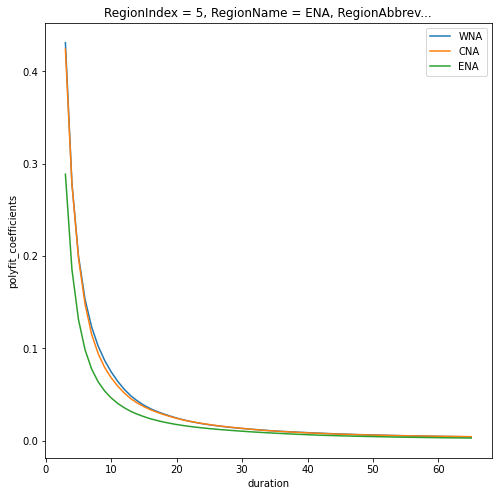

In [19]:
plt.subplots(1,1,figsize=(8,8))

ex_out.sel(RegionIndex=3).plot(label=ex_out.sel(RegionIndex=3).RegionName.values)
ex_out.sel(RegionIndex=4).plot(label=ex_out.sel(RegionIndex=4).RegionName.values)
ex_out.sel(RegionIndex=5).plot(label=ex_out.sel(RegionIndex=5).RegionName.values)

plt.legend()

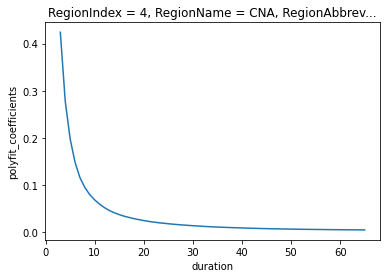

In [13]:
ex_out.sel(RegionIndex=4).plot()